In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
from scipy.integrate import quad

rEarth = 6.378e6 #m
rMoon = 1.737e6 #m
dEM = 3.8e8 #m
mEarth = 5.9e24 #kg
mMoon = 7.3e22 #kg
mCommand = 5500 #kg
G = scipy.constants.G  #m^3 kg^-1 s^-2

In [2]:
def potential(M, xm, ym, x, y,R):
    r = np.sqrt((x-xm)**2 + (y-ym)**2)
    return np.where(r<R, np.nan, -G*M/r)

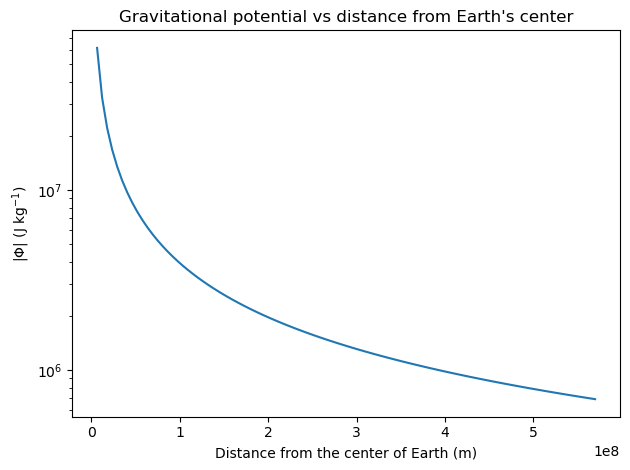

In [11]:
samples = 100
xs =np.linspace(rEarth, 1.5*dEM, samples)
ys = np.linspace(0,0,samples)
pots = potential(mEarth, 0,0,xs,ys,rEarth)
fig, ax = plt.subplots(1,1)
plt.plot(xs, np.abs(pots))
ax.set_xlabel("Distance from the center of Earth (m)")
ax.set_ylabel("|$\\Phi$| (J kg$^{-1}$)")
ax.set_yscale("log")
ax.set_title("Gravitational potential vs distance from Earth's center")
fig.tight_layout()
#fig.savefig("EarthGravPot.png")

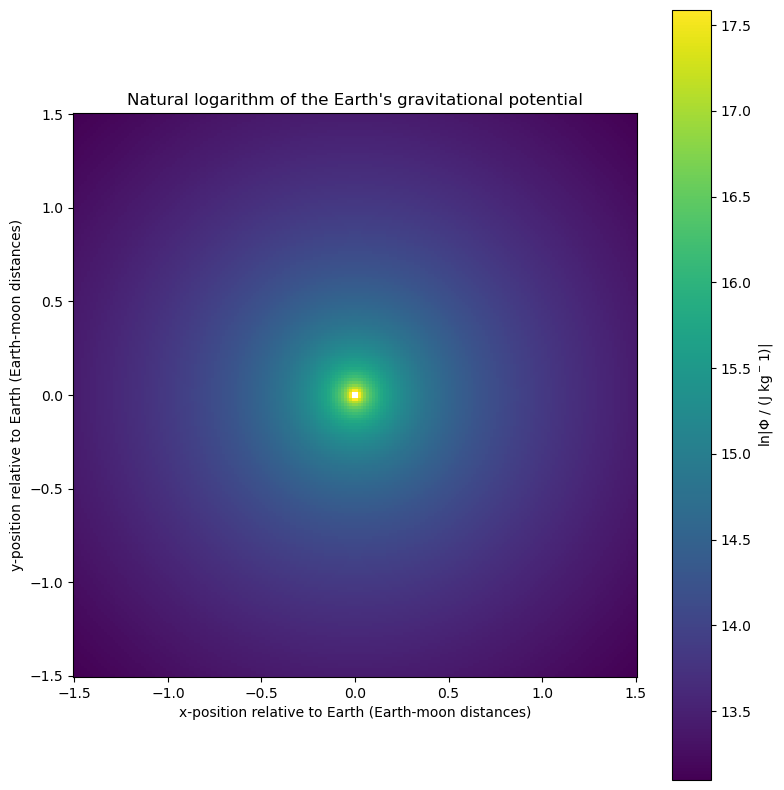

In [12]:
resolution = 200
xs, ys = np.meshgrid(np.linspace(-1.5*dEM, 1.5*dEM, resolution),np.linspace(-1.5*dEM, 1.5*dEM, resolution))
pot = potential(mEarth, 0,0,xs, ys,rEarth)

fig, ax = plt.subplots(1,1, figsize=(8,8))
img = ax.pcolormesh(xs/dEM, ys/dEM, np.log(np.abs(pot)))
fig.colorbar(img, label="ln|$\\Phi$ / (J kg$^-1$)|")
ax.set_xlabel("x-position relative to Earth (Earth-moon distances)")
ax.set_ylabel("y-position relative to Earth (Earth-moon distances)")
ax.set_title("Natural logarithm of the Earth's gravitational potential")
ax.set_aspect(1)
fig.tight_layout()
#fig.savefig("lnEarthGravPotImg.png")

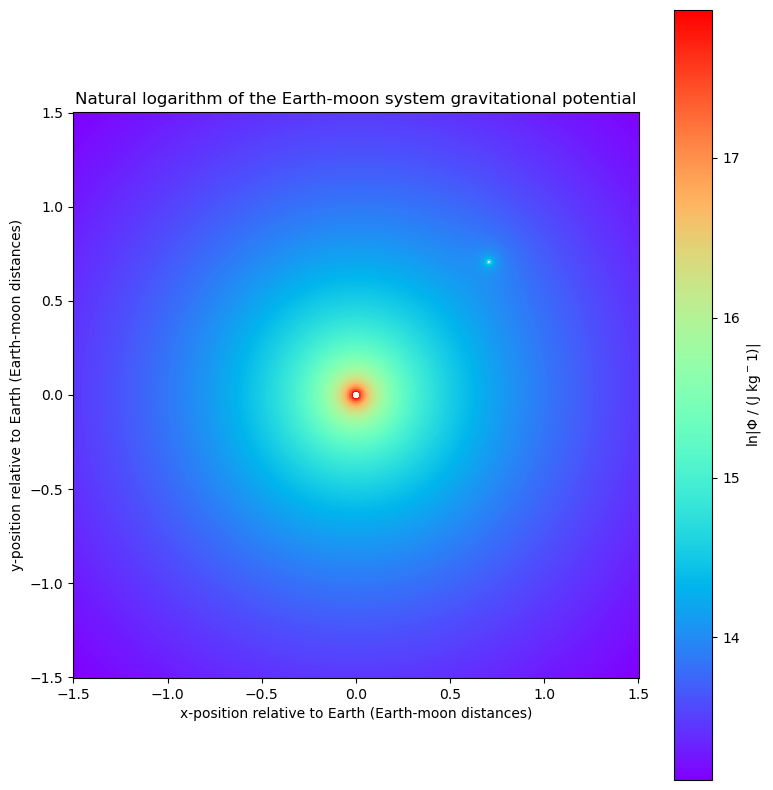

In [13]:
resolution = 800
xs, ys = np.meshgrid(np.linspace(-1.5*dEM, 1.5*dEM, resolution),np.linspace(-1.5*dEM, 1.5*dEM, resolution))
pot = potential(mEarth, 0,0,xs, ys,rEarth) + potential(mMoon, dEM/np.sqrt(2), dEM/np.sqrt(2), xs, ys, rMoon)

fig, ax = plt.subplots(1,1, figsize=(8,8))
img = ax.pcolormesh(xs/dEM, ys/dEM, np.log(np.abs(pot)),cmap = cm.rainbow)
fig.colorbar(img, label="ln|$\\Phi$ / (J kg$^-1$)|")
ax.set_xlabel("x-position relative to Earth (Earth-moon distances)")
ax.set_ylabel("y-position relative to Earth (Earth-moon distances)")
ax.set_title("Natural logarithm of the Earth-moon system gravitational potential")
ax.set_aspect(1)
fig.tight_layout()
#fig.savefig("lnEMGravPotImg.png")

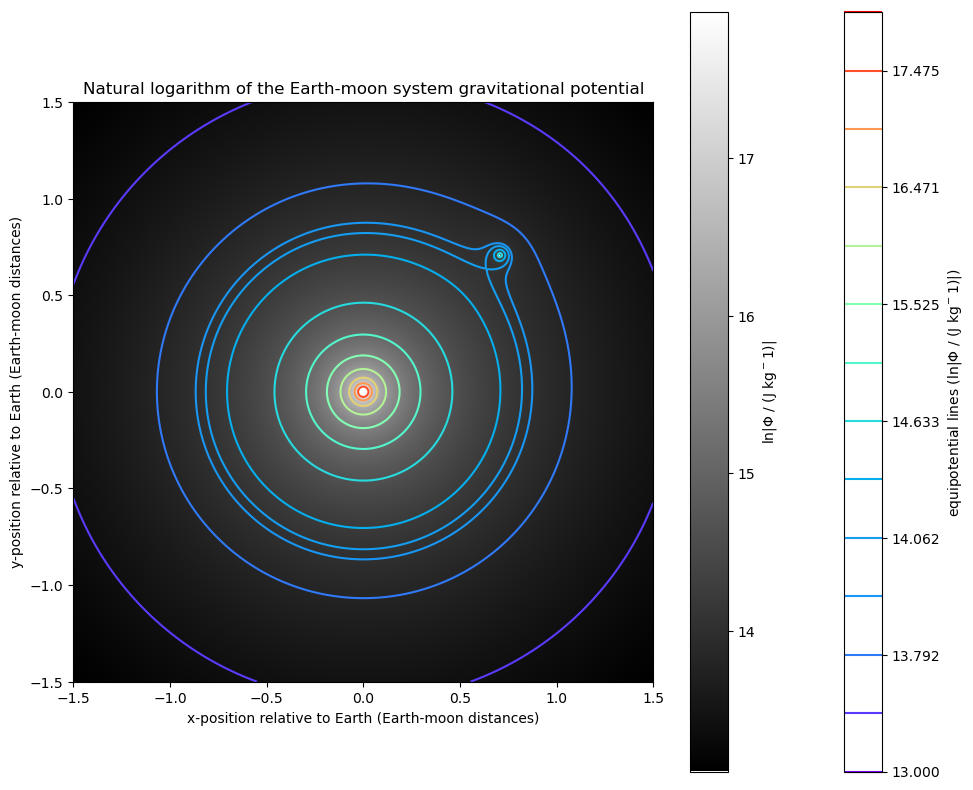

In [14]:
levels = np.sort(np.append(np.logspace(np.log(13), np.log(18), 12, base=np.e), (14,14.062)))

fig, ax = plt.subplots(1,1, figsize=(10,8))
lines= ax.contour(xs/dEM, ys/dEM, np.log(np.abs(pot)), cmap="rainbow", levels=levels)
img = ax.pcolormesh(xs/dEM, ys/dEM, np.log(np.abs(pot)),cmap = cm.grey)
fig.colorbar(lines, label="equipotential lines (ln|$\\Phi$ / (J kg$^-1$)|)")
fig.colorbar(img, label="ln|$\\Phi$ / (J kg$^-1$)|")
ax.set_xlabel("x-position relative to Earth (Earth-moon distances)")
ax.set_ylabel("y-position relative to Earth (Earth-moon distances)")
ax.set_title("Natural logarithm of the Earth-moon system gravitational potential")
ax.set_aspect(1)
fig.tight_layout()
#fig.savefig("Equipotential.png")

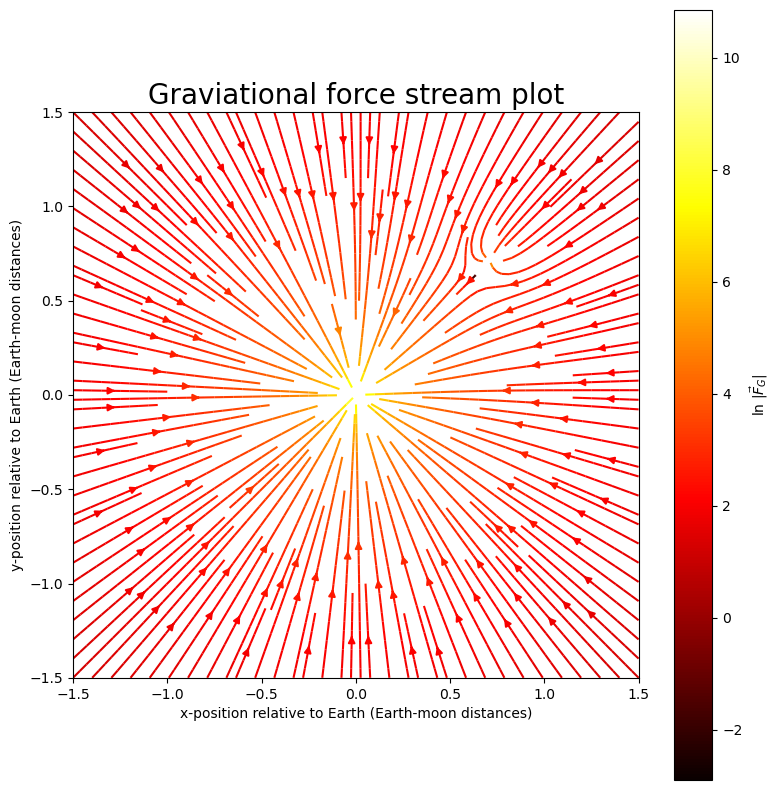

In [7]:
def GravF(M1, m2, x1, y1, x2, y2, R):
    rx = x2-x1
    ry = y2-y1
    r = np.sqrt(rx**2+ry**2)
    rx/=r
    ry/=r
    Coef = -G*M1*m2/r**2
    return np.where(r>R,rx*Coef,np.nan), np.where(r>R,ry*Coef, np.nan)

resolution = 800
xs, ys = np.meshgrid(np.linspace(-1.5*dEM, 1.5*dEM, resolution),np.linspace(-1.5*dEM, 1.5*dEM, resolution))

FEx, FEy = GravF(mEarth, mCommand, 0,0, xs, ys, rEarth)
FMx, FMy = GravF(mMoon, mCommand, dEM/np.sqrt(2), dEM/np.sqrt(2), xs, ys, rMoon)

Fx = FEx+FMx
Fy = FEy+FMy

fig, ax = plt.subplots(1,1, figsize=(8,8))
stream = ax.streamplot(xs/dEM, ys/dEM, Fx, Fy, density=2, color=np.log(np.hypot(Fx, Fy)), cmap=cm.hot)
fig.colorbar(stream.lines, label="ln |$\\vec{F}_G$|")
ax.set_aspect(1)
ax.set_title("Graviational force stream plot", fontsize=20)
ax.set_xlabel("x-position relative to Earth (Earth-moon distances)")
ax.set_ylabel("y-position relative to Earth (Earth-moon distances)")
fig.tight_layout()
#fig.savefig("GravForceStreamPlot.png")

In [8]:
m0 = 2.8e6 #kg
mf = 7.5e5 #kg
mRate = 1.3e4 #kg/s
exhaustVelocity = 2.4e3 #m/s
g = 9.81 #m/s^2

In [9]:
burnTime = (m0-mf)/mRate
print(f"Burn time in seconds: {burnTime}")

Burn time in seconds: 157.69230769230768


74093.98013366401


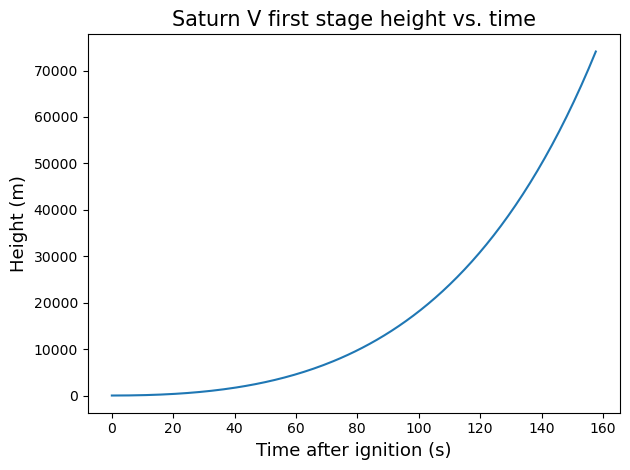

In [10]:
def deltaV(t, mWet, mDry, burnRate, exaustSpeed, g):
    currentMass = mWet - burnRate*t
    currentMass = np.where(currentMass<mDry, mDry, currentMass)
    return exaustSpeed*np.log(mWet/currentMass)-g*t
def h(t):
    return quad(deltaV, 0, t, args=(m0, mf, mRate, exhaustVelocity, g))[0]

ts = np.linspace(0,burnTime,200)
hs = np.vectorize(h)(ts)
fig, ax = plt.subplots(1,1)
ax.plot(ts, hs)
ax.set_title("Saturn V first stage height vs. time", fontsize=15)
ax.set_xlabel("Time after ignition (s)", fontsize=13)
ax.set_ylabel("Height (m)", fontsize=13)
fig.tight_layout()
print(hs[-1])
#fig.savefig("SaturnVheightVtime.png")